In [82]:
# import python modules
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import sklearn, sys
%matplotlib inline
from openbabel import openbabel

# import rdkit
import rdkit
from rdkit import Chem
import rdkit.Chem.GraphDescriptors as graph
print(rdkit.__version__)

# import SA_Score
from sascorer import *

# import Boettcher score
from boettcher import *

# import SCScore
from standalone_model_numpy import *

2020.03.1


In [83]:
def plot_models(mean_complexity, boettcher, scscore, sa_score, bertz, save=False):

    fig = plt.figure(figsize=(15,10))
    pos = 1
           
    metrics = [mean_complexity, boettcher, scscore, sa_score, bertz]            
    names = ['mean complexity', 'Boettcher', 'SCScore', 'SA_Score', 'Bertz']
    for x in range(len(metrics)):
        for y in range(x+1,len(metrics)):
                         
            # create subplot
            plt.subplot(2,5,pos)
            plt.grid(alpha=0.2)
            plt.title(names[y] + ' vs '+ names[x], fontsize=10)

            # add r2-score patches
            mask = ~np.isnan(metrics[x]) & ~np.isnan(metrics[y])
            linreg = sp.stats.linregress(metrics[x][mask], metrics[y][mask])
            rsq = linreg.rvalue
            #rsq = r2_score(metrics[x], metrics[y])
            rsq_patch = mpatches.Patch(label="R2 = {:04.2f}".format(rsq))
            #plt.xlim(min_val,max_val)
            #plt.ylim(min_val,max_val)
            plt.scatter(metrics[x], metrics[y], alpha=0.5)
            plt.legend(handles=[rsq_patch], fontsize=12)
            #fig.text(0.5, 0.08, names[x], ha='center', va='center', fontsize=15)
            #fig.text(0.09, 0.5, names[y], ha='center', va='center', rotation='vertical', fontsize=15)
            pos += 1
    if save:
        plt.savefig(save, dpi = 300)
    plt.show()

In [84]:
# Ertl SA_Score (J. Cheminform. 2009, 1, 8) 
def get_sa_score(mols):
    # read fragment scores from file
    readFragmentScores("fpscores")

    SA_Scores = []

    for i, mol in enumerate(mols): 
        try: 
            score = calculateScore(mol)
        except: 
            score = np.nan

        SA_Scores.append(score)

    return SA_Scores

In [85]:
# Boettcher Score (J. Chem. Inf. Model. 2016, 56, 3, 462–470)
def get_boettcher_score(mols):
    obConversion = openbabel.OBConversion()
    obConversion.SetInAndOutFormats("smi", "smi")
    bottch = BottchScore("False")

    Boettcher_Scores = []

    for i, smi in enumerate(mols): 
        try:
            mol = openbabel.OBMol()
            obConversion.ReadString(mol, smi)
            score=bottch.score(mol)
        except: 
            score = np.nan

        Boettcher_Scores.append(score)

    return Boettcher_Scores

In [86]:
# Bertz Complexity Score (JACS 1981, 103, 3241-3243)
def get_bertz_score(mols):
    bertz_scores = []

    for i, mol in enumerate(mols): 
        try: 
            score = graph.BertzCT(mol)
        except: 
             score = np.nan

        bertz_scores.append(score)

    return bertz_scores

In [87]:
#  SCScore (J. Chem. Inf. Model. 2018, 58, 2, 252)
def get_scscore(mols):
    model = SCScorer()
    model.restore(os.path.join('.', 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))

    SC_Scores = []

    for i, smi in enumerate(mols): 
        try:
            (smi, score) = model.get_score_from_smi(smi)
        except: 
            score = np.nan

        SC_Scores.append(score)

    return SC_Scores

In [88]:
# the molecules from the dataframe
mol_smiles = data['SMILES']

addHs = False

if addHs != True:
    mol_objects = [Chem.MolFromSmiles(mol) for mol in mol_smiles]
else:
    mol_objects = [Chem.AddHs(mol) for mol in mol_objects]

In [89]:
# Define path and csv files 
DATA_DIR = './'
# Molecules taken from Merck JCIM, 2014, 54, 6, 1604
INPUTS = 'ci5001778_si_002.csv'

# Load the raw data as a pandas dataframe
data = pd.read_csv(DATA_DIR + INPUTS)

In [90]:
# generate different complexity metrics
data['boettcher'] = get_boettcher_score(mol_smiles)
data['scscore'] = get_scscore(mol_smiles)
data['sa_score'] = get_sa_score(mol_objects)
data['bertz'] = get_bertz_score(mol_objects)

Restored variables from ./models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


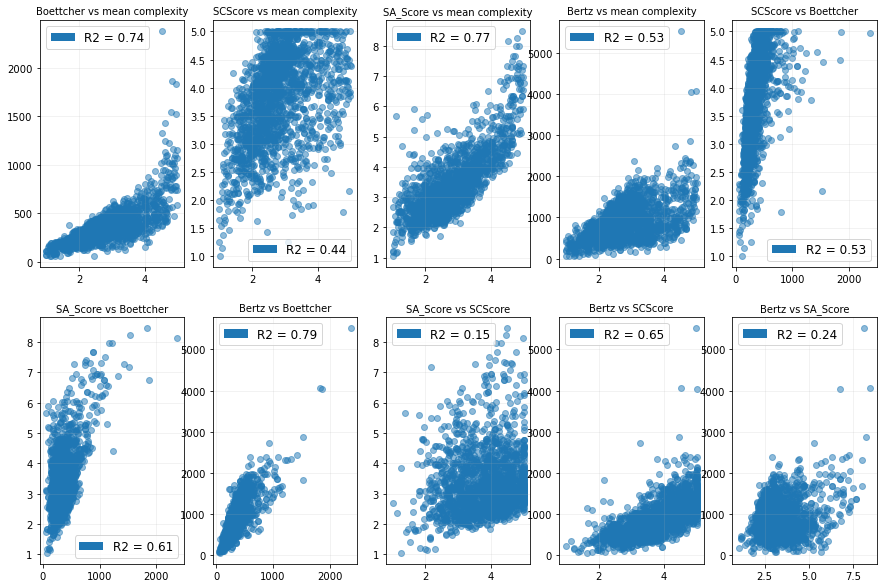

In [91]:
data.dropna(inplace=True, subset=['meanComplexity','boettcher', 'scscore', 'sa_score', 'bertz'])
plot_models(data['meanComplexity'], data['boettcher'], data['scscore'], data['sa_score'], data['bertz'])